In [3]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))
device = 'cuda:7'

In [60]:
import torchvision.transforms as T
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked/', train=False, transform=transform)
# valid_dataset = torchvision.datasets.CIFAR10(root='/root/data/cifar10', train=False, transform=transform)
# interpolation = torch.from_numpy(np.load('/root/results/cifar10/image_simple_gradient_ascent_interpolation.npy'))

# interpolation.shape
model = torch.jit.load("/data8/donghun/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to(device)
# classifier = torch.jit.load("/root/data/cifar10/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to('cuda:0')

# ae = torch.jit.load("/root/data/cifar10/cifar10/results/ae/script_model.pt",  map_location='cpu').eval().to('cuda:0')
# bottle = torch.load("/root/ig_inversion/results/bottleneck_ae/results/model_best.pt",  map_location='cpu').eval().to('cuda:0')

bottleneck = torch.load("/home/dhlee/code/ig_inversion/ig_pkg/bottleneck_ae/results/cifar10_2/model_best.pt",  map_location='cpu').eval().to(device)

In [44]:
image_baseline = []
latent_baseline = []
coeff = [-1, -0.5, 0, 0.5, 1]
for i in range(5):
    temp = torch.ones((3, 32, 32)) * coeff[i]
    # print(torch.mean(temp))
    image_baseline.append(temp)
    t1, t2 = bottleneck.encode(temp.unsqueeze(0).to(device))
    # print(t1)
    latent_baseline.append(t1.detach().cpu())
latent_baseline

[tensor([[ 0.9790, -0.5944,  0.9840,  0.3247, -0.9923, -0.8754, -0.6798,  0.6908]]),
 tensor([[ 0.9657, -0.4447,  0.9570,  0.1508, -0.9633, -0.8206, -0.5215,  0.3061]]),
 tensor([[-0.0722, -0.1693,  0.1727, -0.0027,  0.0215, -0.0958, -0.0955, -0.0293]]),
 tensor([[ 0.9618, -0.3241,  0.8949,  0.0161, -0.7720, -0.8048, -0.1046, -0.4961]]),
 tensor([[ 0.9800, -0.0379,  0.8815, -0.1404, -0.6166, -0.8239,  0.1591, -0.8084]])]

In [48]:
# x_hat, loss_dict, info = bottleneck(temp.unsqueeze(0).to(device))
# info['bottleneck']
# info
latent_baseline[0][0]


tensor([ 0.9790, -0.5944,  0.9840,  0.3247, -0.9923, -0.8754, -0.6798,  0.6908])

In [31]:
latent1, latent2 = [ 0.01552928,  0.571816  , -0.03334171, -0.40915   ,  0.1417619 ,
         0.08252704,  0.2810632 , -0.63116264], [-0.06604326, -0.18297149,  0.04879477,  0.7596098 , -0.00115259,
        -0.06883926,  0.28585574, -0.544351  ]

latent = np.array([latent1, latent2])
latent

array([[ 0.01552928,  0.571816  , -0.03334171, -0.40915   ,  0.1417619 ,
         0.08252704,  0.2810632 , -0.63116264],
       [-0.06604326, -0.18297149,  0.04879477,  0.7596098 , -0.00115259,
        -0.06883926,  0.28585574, -0.544351  ]])

In [36]:
for i in range(5):
    temp1= latent_baseline[i][0]
    temp1 = np.array(temp1)
        
    ans = np.linalg.lstsq(latent.T, temp1, rcond=None)[0]
    print(ans)
    print(latent1 * ans[0] + latent2 * ans[1])
    print(temp1)
    break
    

[-1.3303247 -0.1702153]


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [43]:
def mul_float(list1, list2, coeff):
    ans = []
    for i in range(len(list1)):
        t1 = list1[i]
        t2 = list2[i]
        
        c = t1 * coeff[0] + t2 * coeff[1]
        ans.append(c)
        
    return ans

print(mul_float(latent1, latent2, ans))
print(temp1)

[-0.009417411250020699, -0.7295564009362563, 0.03604968379139997, 0.41500513873858386, -0.18839316860040162, -0.09807026422045734, -0.42256233851853287, 0.9323081198983701]
[ 0.978988   -0.5943823   0.9840166   0.32468495 -0.99229264 -0.8753998
 -0.6797708   0.69082797]


In [37]:
print(latent1 * -1.33 + latent2 * -0.17)
print(temp1)

TypeError: can't multiply sequence by non-int of type 'float'

In [61]:
a = np.linspace(-1, 1, 11)
b = np.linspace(-1, 1, 11)

dots = []
for i in a:
    for j in b:
        dots.append(torch.tensor([i, j],  dtype=torch.float32, device=device).unsqueeze(0))
# dots

new = []
dot = torch.stack(dots)
# dot.shape
for i in dot:
    i = i.to(device)
    new.append(bottleneck.decode(i).squeeze(0))
new = torch.stack(new)    
new.shape

torch.Size([121, 3, 32, 32])

In [64]:
a

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

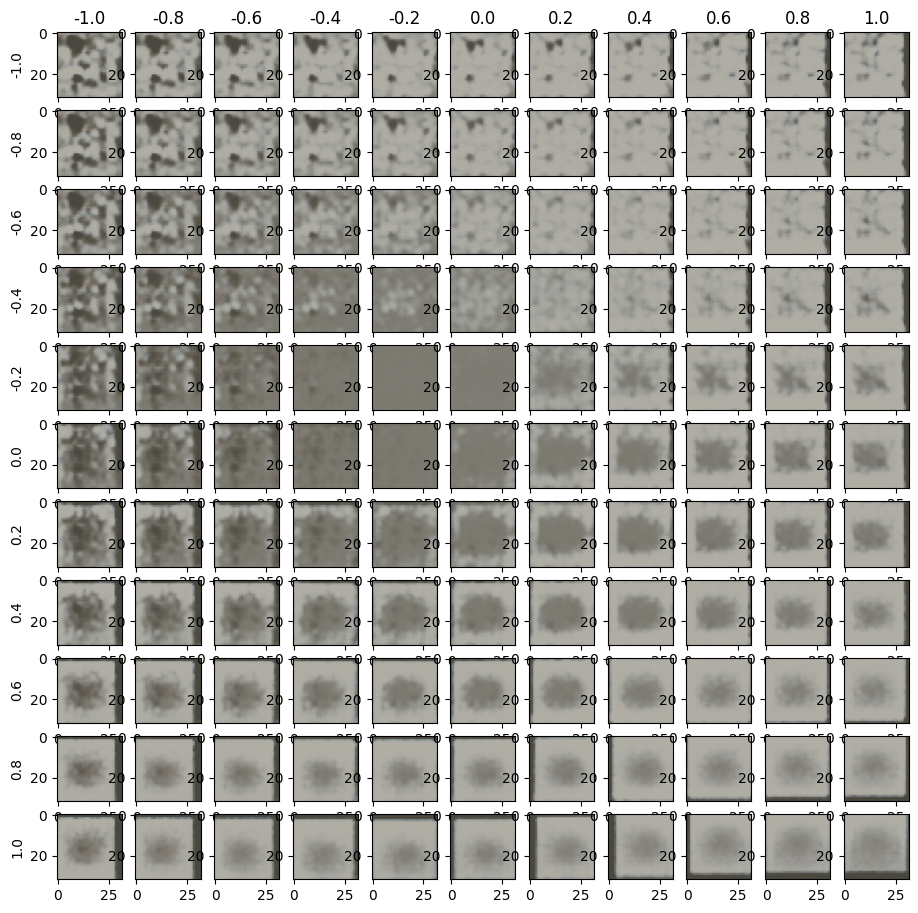

In [71]:
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2023, 0.1994, 0.2010]

fig, axes = plt.subplots(11, 11, figsize = (11, 11))
axes_flat = axes.flat

for i in range(121):
    ax = next(axes_flat)
    ax.imshow(convert_to_img(new[i],CIFAR10_MEAN, CIFAR10_STD ))
    
    if i % 11 : pass
    else: ax.set_ylabel(round(a[i//11], 1))
    
    if i < 11: ax.set_title(round(a[i%11], 1))
    # if i > 120 - 11: ax.set_xlabel(round(a[i%11], 1))

In [73]:
mnist_bottle = torch.load("/home/dhlee/code/ig_inversion/ig_pkg/old_bottleneck_ae/results/model_best.pt",  map_location='cpu').eval().to(device)

a = np.linspace(-1, 1, 11)
b = np.linspace(-1, 1, 11)

dots = []
for i in a:
    for j in b:
        dots.append(torch.tensor([i, j],  dtype=torch.float32, device=device).unsqueeze(0))
# dots

new = []
dot = torch.stack(dots)
# dot.shape
for i in dot:
    i = i.to(device)
    new.append(mnist_bottle.decode(i).squeeze(0))
new = torch.stack(new)    
new.shape


torch.Size([121, 1, 32, 32])

Text(0.5, 1.0, 'MNIST')

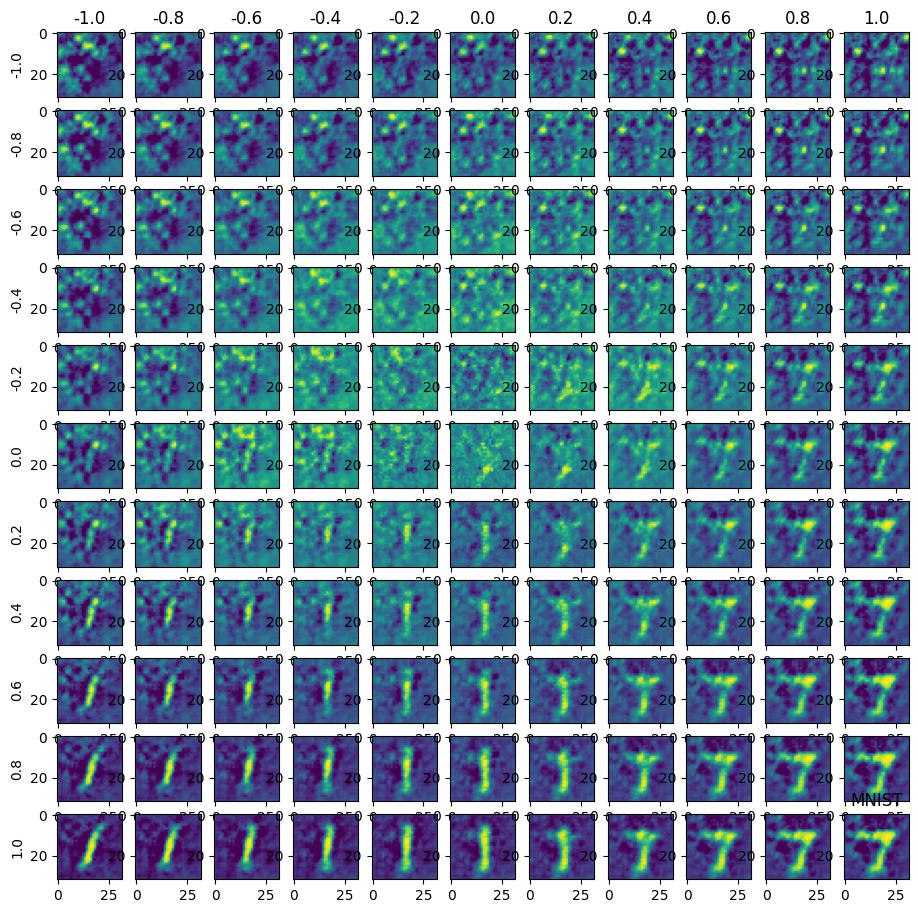

In [76]:
MNIST_MEAN = [0.1307]
MNIST_STD  = [0.3081] 

fig, axes = plt.subplots(11, 11, figsize = (11, 11))
axes_flat = axes.flat

for i in range(121):
    ax = next(axes_flat)
    ax.imshow(convert_to_img(new[i],MNIST_MEAN, MNIST_STD ))
    
    if i % 11 : pass
    else: ax.set_ylabel(round(a[i//11], 1))
    
    if i < 11: ax.set_title(round(a[i%11], 1))
    # if i > 120 - 11: ax.set_xlabel(round(a[i%11], 1))
plt.title('MNIST')

prev

In [17]:
a = np.linspace(-1, 1, 5)
b = np.linspace(-1, 1, 5)

dots = []
for i in a:
    for j in b:
        dots.append(torch.tensor([i, j],  dtype=torch.float32, device=device).unsqueeze(0))
# dots

new = []
dot = torch.stack(dots)
# dot.shape
for i in dot:
    i = i.to(device)
    new.append(bottleneck.decode(i).squeeze(0))
    


In [21]:
# new = torch.stack(new)
# print(new.shape)
torch.save(new, '/home/dhlee/code/ig_inversion/results/baseline/cifar10_baseline_2.pt')

pca

In [50]:
from tqdm import tqdm

bottleneck = torch.load("/home/dhlee/code/ig_inversion/ig_pkg/bottleneck_ae/results/cifar10_8/model_best.pt",  map_location='cpu').eval().to(device)
latent = []
for i in tqdm(valid_dataset):
    input, label = i
    input = input.to(device)    
    x_hat, loss_dict, info = bottleneck(input.unsqueeze(0))
    latent.append(info['bottleneck'])
    # print(info['bottleneck'].shape)
    # print(x_hat.shape)
    # print(latent['bottleneck'].shape)
    # if i ==2: break
latent = torch.stack(latent)
# print(latent.shape)

100%|██████████| 10000/10000 [00:18<00:00, 544.36it/s]


In [8]:
# latent = torch.stack(latent)
# len(latent)
latent.shape

torch.Size([10000, 1, 8])

In [9]:
a = torch.load('/home/dhlee/code/ig_inversion/results/baseline/cifar10_baseline_2.pt')
a[0].shape

torch.Size([3, 32, 32])

In [51]:
from sklearn.decomposition import PCA

num = latent.clone().detach().cpu().numpy()
num = num.reshape(-1, 8)

pca = PCA(n_components=2)
pca.fit(num)


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


PCA(n_components=2)

In [57]:
# pca.transform()
for i in range(5):
    temp = latent_baseline[i][0].numpy().reshape(1, -1)
    new = pca.transform(temp)
    print(new)

[[-0.95192975 -0.2068458 ]]
[[-0.49853814 -0.11587019]]
[[0.2626021  0.00073764]]
[[0.2794992  0.31148148]]
[[0.7995451  0.38491508]]


In [16]:
pca.get_params(['deep'])

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [21]:
# latent1, latent2 = pca.components_
pca.components_

array([[ 0.01552928,  0.571816  , -0.03334171, -0.40915   ,  0.1417619 ,
         0.08252704,  0.2810632 , -0.63116264],
       [-0.06604326, -0.18297149,  0.04879477,  0.7596098 , -0.00115259,
        -0.06883926,  0.28585574, -0.544351  ]], dtype=float32)

In [29]:
a = [-1.0, -0.5, 0.0, 0.5, 1.0]
b = [-1.0, -0.5, 0.0, 0.5, 1.0]

new_latent = []
for i in a:
    for j in b:
        temp = i * latent1 + j * latent2
        new_latent.append(torch.tensor(temp))
# for 
# latent1

In [31]:
new_st = torch.stack(new_latent)
print(new_st.shape)
# new_latent[0]

torch.Size([25, 8])


In [35]:
# c = torch.zeros((1, 2))
ch = bottleneck.decode(new_st.to(device))
ch.shape

torch.Size([25, 3, 32, 32])

In [36]:
torch.save(ch, '/home/dhlee/code/ig_inversion/results/baseline/cifar10_baseline_8.pt')